# Introduction

For this specific ML scenario, a dataset referring to a census made in California in 1990 it is provided. The data provided is composed of a sample block of the entire California area. This block group on average includes 1425.5 individuals living in a geographically compact area (similar behaviors).

## Statement
Since 1990, the median house value of California houses has increased with time. A real estate agency contacts us to see if we can study and forecast the average value of a house in the year 1990. His hypothesis focuses on obtaining a model with a certain margin of improvement over the actual standard deviation (STD) of the median house value. Over this premise, they pretend to study the value of each parameter of the dataset to denote which were the most important factors when establishing the price of a house.

For us, the practice will be focused on studying as our objective the `median_house_value` parameter since this one contains the median house value of a certain profile of the house. To do so, it will be necessary to rely on the other 9 parameters provided by the 1990 California census. In general terms, the CSV file provided  [(get CSV dataset)](https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv) has 10 different parameters which we will need to evaluate and understand to see if these ones can benefit our final model or not.

To evaluate the actual ML scenario of this practice, we kindly ask you to proceed by aiming into the creation of 3 ML models. The actual procedure will replicate how ML projects are handled. To do so, Data Scientists normally follow a "CRISP-DM"-like methodology (like the one seen in class) to correctly handle the different parts of the challenge (_see CRISP-DM phases explained down below_). Then, when the first Modeling phase is achieved, they start by creating a first-version model called "_Baseline_" designed to be improved in future iterations. Because of this premise, this practice asks you to repeat the development cycle composed by: _Data Understanding_ $\rightarrow$ _Data Prepartion_ $\rightarrow$ _Modeling_ $\rightarrow$ _Evaluation_ two more times once your _Baseline_ model will be achieved. The accuracy and performance of the _Baseline_ model (as well as that of the following models) will not be transcendental for the definition of the final grade of this assignment but what will be the most relevant is to try to improve two times this _Baseline_ model achieved by you. In other words, you have to develop a total amount of 3 different ML models to improve at each iteration the model achieved in the last one.

To help you in this task, we provide down below a "defacto" paragraph which implies all the conclusions we want you to specify when moving from one interaction to the following one. You can access this same Markdown cell to copy the paragraph and use it in your development.

> <u>__Current iteraion__:</u>
> - __ML model used__: Explain the algorithm behind the model used and why you have chosen it.
> - __Performance evaluation__: Explain the metrics achieved by your model as well as how are you evaluating the actual performance.
> - __Model Evaluation__: Explain why you think your model is not performing the best it could do (_if is the case_).
>
> <br>
>
> <u>__Following iteration__:</u>
> - __Improvement ideas__: Brief introduction to the main points you will try to handle in the next iteration to try to improve the actual performance of your model.
> - __Hypothesis__: The main idea/s in which your next iteration is sustained into.
> - __Expected solution__: Brief explanation about why do you think this following iteration will improve the actual scenario achieved by the current model.

<br>
<br>
<br>
<br>

#### CRISP-DM phases:
- Iteration 1:
    - __Bussines Understanding__: This task is already solved by the practice statement. However, it is important to take all the important points out of this statement to correctly proceed into the development of the solution.
    - __Data Understanding__: [ _Required_ ]
    - __Data Preparation__: [ _Required_ ]
    - __Modeling__: [ _Required_ ]
    - __Evaluation__: [ _Required_ ]
- Iteration 2:
    - __Data Understanding__: [ _If Necessary_ ]
    - __Data Preparation__: [ _Required_ ]
    - __Modeling__: [ _Required_ ]
    - __Evaluation__: [ _Required_ ]
- Iteration 3:
    - __Data Understanding__: [ _If Necessary_ ]
    - __Data Preparation__: [ _Required_ ]
    - __Modeling__: [ _Required_ ]
    - __Evaluation__: [ _Required_ ]
- Final conclusion: [ _Optional_ ] _Final summary comparing the three models achieved and each one of the hypotheses which improved the overall project solution_.

## Text Formats

Procedures are written as plain markdown

> Comments are witten as citation quotes


# Dependencies

In [1]:
#@title
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotly.express as px
import plotly.graph_objects as go
import requests
import scipy
import seaborn as sns

from google.colab import drive
from os import sep
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Presets

## Static Params

In [2]:
#@title
PAIA_FOLDER = 'PAIA'  # Your PAIA folder name
PROJECT_NAME = 'practice'  # Your project name (the same name as the folder)

PROJECTS_ROUTE = 'drive' + sep + 'MyDrive' + sep + PAIA_FOLDER + sep + 'projects' + sep
START_PROJECT = PROJECTS_ROUTE + PROJECT_NAME + sep

PATH_NOTEBOOKS = 'notebooks'
PATH_DATA_RAW = 'data' + sep + 'raw' + sep
PATH_DATA_PROCESSED = 'data' + sep + 'processed' + sep
PATH_MODELS = 'models' + sep

In [3]:
#@title
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#@title
%cd $START_PROJECT

/content/drive/MyDrive/PAIA/projects/practice


## General Functions

In [5]:
#@title
prepare_path = lambda path: not os.path.exists(path) and os.makedirs(path)

In [6]:
#@title
def model_validation(model, x_test, y_test, plot_samples=0, units='', obj_col='', figsize=(7, 3), multiple_y_axis=[]):
    y_pred = model.predict(x_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print('- MAE:\t\t', round(mae, 4), units)
    print('- MSE:\t\t', round(mse, 4), units + '2' if units else '')
    print('- RMSE:\t\t', round(rmse, 4), units)
    print('- var(Y_pred):\t', round(y_pred.var(), 4), units + '2' if units else '')
    print('- std(Y_pred):\t', round(y_pred.std(), 4), units)
    print('- R2:\t\t', round(r2, 4), end='\n\n')

    x_test = x_test if plot_samples == 0 else x_test.iloc[:plot_samples]
    y_test = y_test if plot_samples == 0 else y_test.iloc[:plot_samples]
    y_pred = y_pred if plot_samples == 0 else y_pred[:plot_samples]
    fig = plt.figure(figsize=figsize)
    ax1 = sns.scatterplot(x=range(0, len(y_test)), y=y_test, label='Test')
    ax2 = sns.scatterplot(x=range(0, len(y_pred)), y=y_pred, label='Pred')
    if multiple_y_axis:
        for idx, y_pred in enumerate(multiple_y_axis, start=1):
            y_pred = y_pred if plot_samples == 0 else y_pred[:plot_samples]
            ax2 = sns.scatterplot(x=range(0, len(y_pred)), y=y_pred, label='IT#' + str(idx) + ' Pred')
    ax2.axhline(y_test.mean(), ls='-', color='green', linewidth=2.5, label='Mean')
    plt.legend()
    plt.title('Predicted Test Data')
    plt.show()

In [7]:
#@title
from math import radians, cos, sin, asin, sqrt

# Source - academic: https://es-academic.com/dic.nsf/eswiki/1288404#:~:text=Es%20un%20caso%20especial%20de,2%20(%CE%B8%2F2).
# Source - code: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def haversine_formula(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return km

# Data Loading

<u>Questions:</u>
- Does all the data look correct?
- Are there any anomalies referring to the columns read or the content of those ones?

Load and prove that the raw data was correctly stored as a `pd.DataFrame()` object well formatted.

In [8]:
#@title
housing_df_raw = pd.read_csv(PATH_DATA_RAW + 'housing.csv')
housing_df_raw.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Data Understanding

<u>Questions:</u>
- Are there any anomalies when deeply looking into the parameters of the dataset?
  - Tip: Remember to make usage of `.head()`, `.info()`, `.describe()` and `.histplot()`
  - Tip: Remember to correclty specify and validate each parameter data type.
  - Tip: This section will report way more value to your practice if you try to study and explain each columns following the format:
  > - column: <_column definition_>.
  >   - expected behaviour or value: <_Of the column based on its inspection, plot or definition_>.

## Columns Study

Brief definition of each column value and an expected value which can end up providing to the study.

In [9]:
housing_df_raw.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

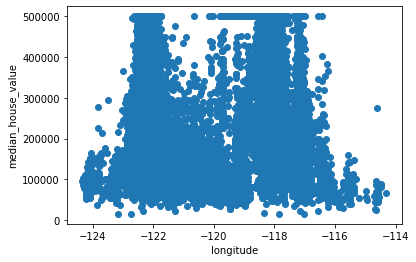

In [10]:
# plt.scatter(x, y)
plt.scatter(housing_df_raw['longitude'], housing_df_raw['median_house_value'])
plt.xlabel('longitude')
plt.ylabel('median_house_value')
plt.show()

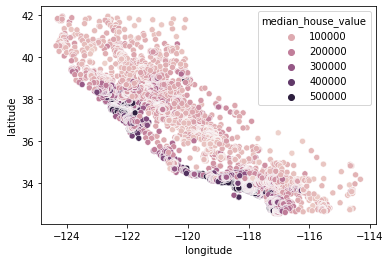

In [11]:
sns.scatterplot(data=housing_df_raw, x='longitude', y='latitude', hue='median_house_value')
plt.show()

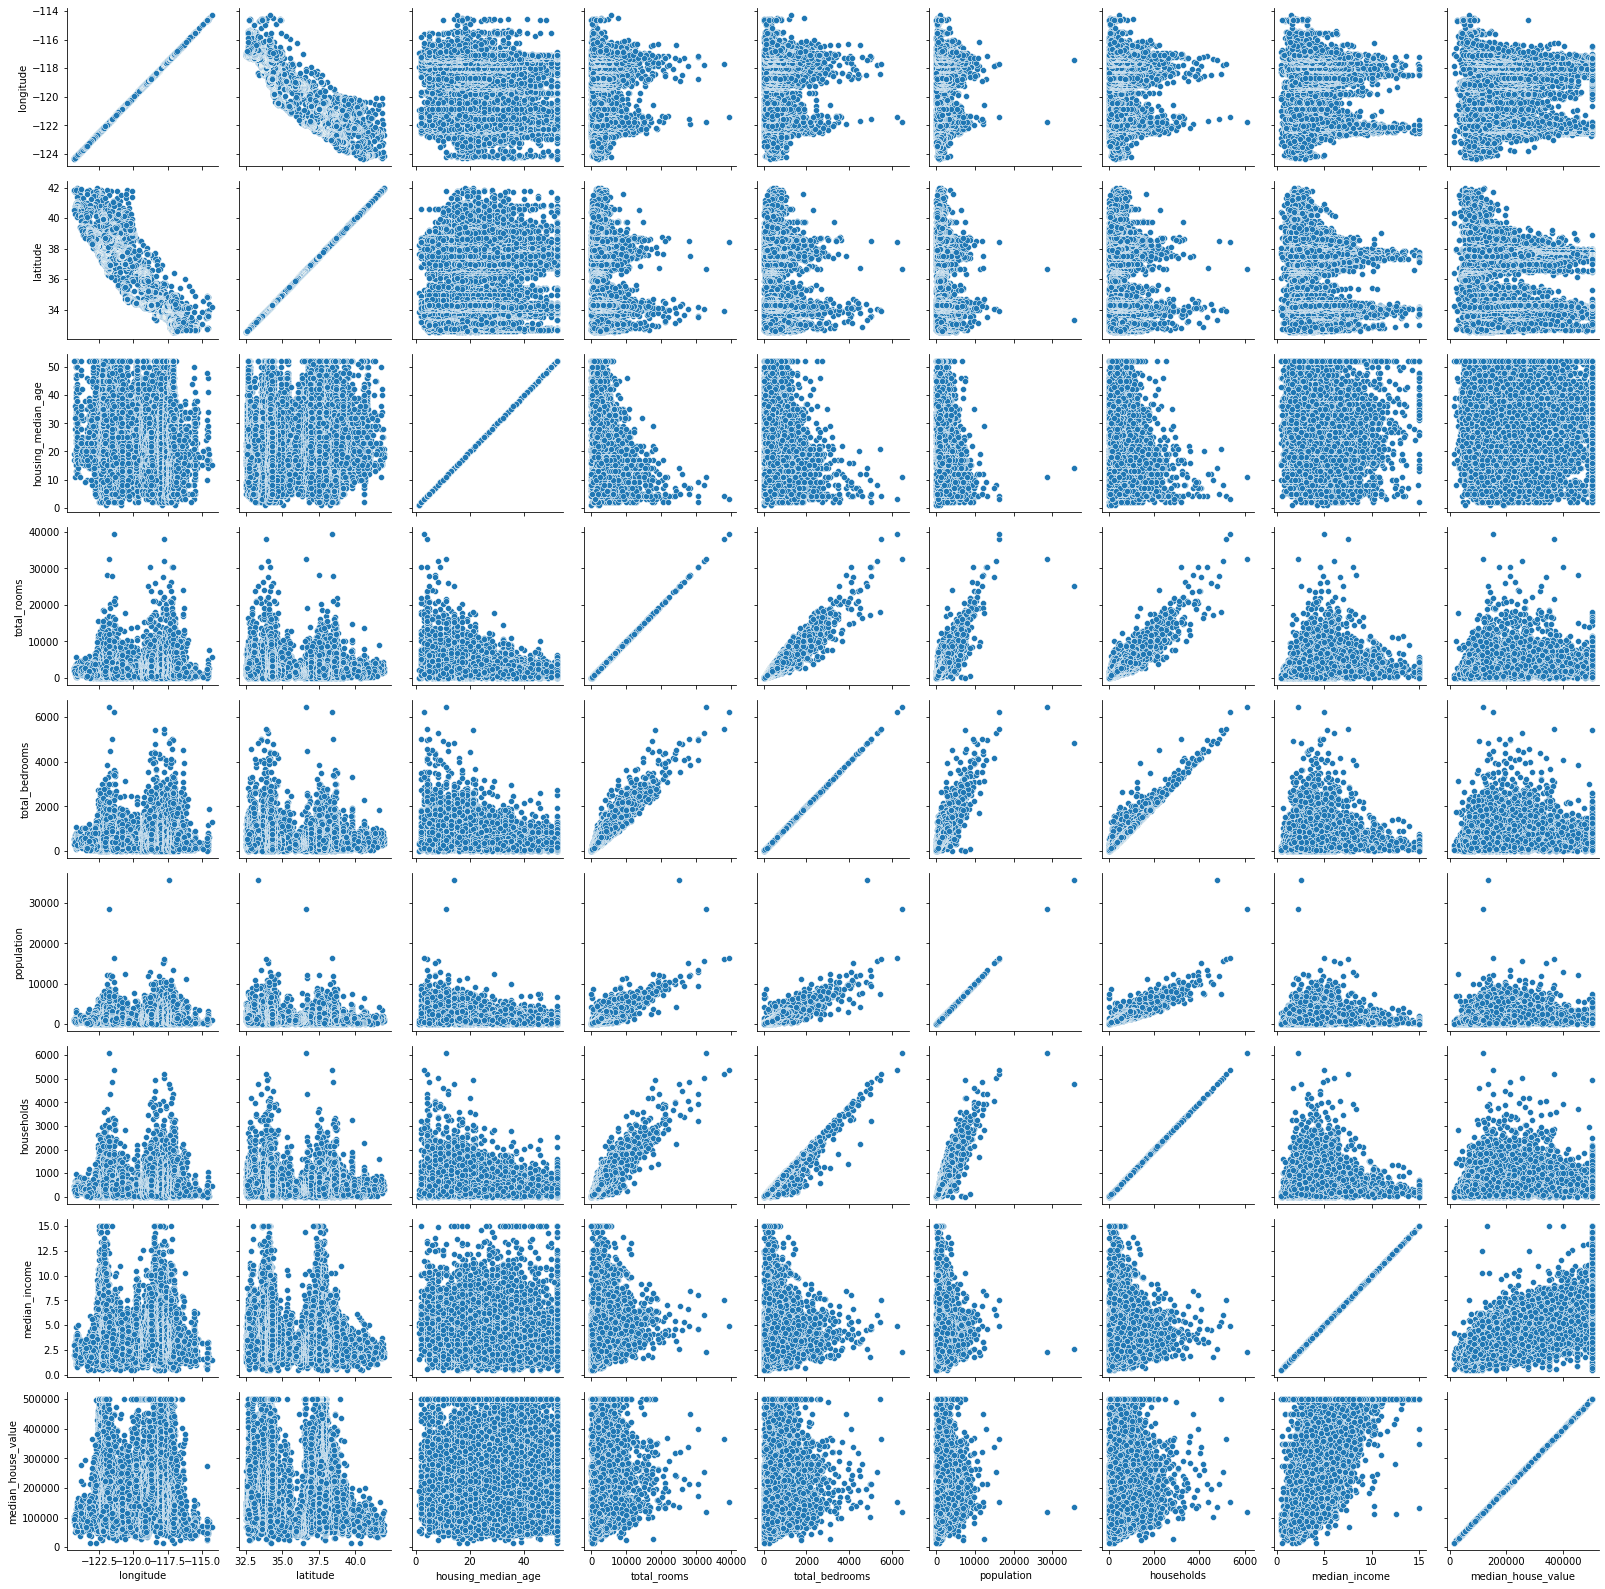

In [12]:
g = sns.PairGrid(housing_df_raw)
g.map(sns.scatterplot)

  Looking at the graphs obtained, it is seen that the median_house_value increases in certain intervals of the longtitude values. It has been observed that high priced homes are only found in those with some longtitude. The same thing seems to happen with the latitude property. It has been determined that the latitude values ​​of the houses with high prices are in the ranges where they change. Housing_median_age property has no effect on price. Because, as can be seen in the graph, there are various median_house_values ​​according to various housing_median_age values ​​and there is no relationship between them. Similar graphs were obtained for the total_rooms and total_bedrooms properties. For both, the price is expected to increase as the number of rooms or bedrooms increases. However, looking at the graph, although the number of rooms or bedrooms increases at some points, the price decreases. Therefore, it is not possible to directly comment on the number of rooms or beds. A straight line is obtained on the graph for the Population property. Therefore, the population property is not useful for commenting on the price. There is no range in which a price increase can be observed for Households. Therefore, a relationship cannot be established between median_house_value. For median_income, it is seen that the value of median_house_value increases in a certain range. So it's a useful feature to be able to comment on the median_house_value.


  In summary, the properties that should be used when creating a model are longitude, latitude, and median_income. Our objective value is median_house_value.

In [13]:
#sns.boxplot(data=housing_df_raw, x='longitude', y='latitude', hue='median_house_value')
#plt.show()

# Data Preparation (I)

<u>Questions:</u>
- Looking back at the Data Understanding section, what parameters are expected to be addressed/corrected in this section?

In [14]:
housing_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [15]:
housing_df_raw['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

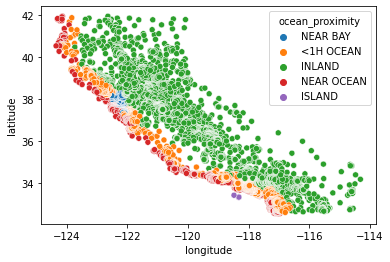

In [16]:
sns.scatterplot(data=housing_df_raw, x='longitude', y='latitude', hue='ocean_proximity')
plt.show()

In [17]:
housing_df_raw['ocean_proximity_int'] = housing_df_raw['ocean_proximity'].replace({'ISLAND':0,'NEAR OCEAN':1,'<1H OCEAN':2, 'NEAR BAY':3, 'INLAND':4}).astype(int)
#housing_df_raw['ocean_proximity'].replace({'ISLAND':0,'NEAR BAY':3})

In [18]:
housing_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   longitude            20640 non-null  float64
 1   latitude             20640 non-null  float64
 2   housing_median_age   20640 non-null  float64
 3   total_rooms          20640 non-null  float64
 4   total_bedrooms       20433 non-null  float64
 5   population           20640 non-null  float64
 6   households           20640 non-null  float64
 7   median_income        20640 non-null  float64
 8   median_house_value   20640 non-null  float64
 9   ocean_proximity      20640 non-null  object 
 10  ocean_proximity_int  20640 non-null  int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 1.7+ MB


In [19]:
housing_df_raw.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_int
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


# Modeling & Evaluation (I) - _Baseline_

<u>Questions:</u>
 - _----    In this section the main questions are addressed by the final comments section in which different conclusions need to be extracted and defended    ----_

The model that should have been used for Model 1 was LinearRegression. Because the objective to be achieved must be a value. First, the LinearRegression model was created using the features selected for the independent values.

In [20]:
train_pct = 0.8
train, test = train_test_split(housing_df_raw, train_size=0.8) #split

print('\n\nFunction output:\n\t- Train:', len(train), '\n\t- Test:', len(test))



Function output:
	- Train: 16512 
	- Test: 4128


In [21]:
from sklearn import linear_model

housing_df_raw.columns

x_train = train[['longitude', 'latitude','median_income']]
y_train = train['median_house_value']

#regr = linear_model.LinearRegression()
#regr.fit(x_train, y_train)

#predictedMedianValue = regr.predict([[-122.24, 37.85, 7.2574]])


#print(predictedMedianValue)



In [22]:
# importing module
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR1 = LinearRegression()
# fitting the training data
LR1.fit(x_train,y_train)

LinearRegression()

In [23]:
x_test = train[['longitude', 'latitude','median_income']]
y_test = train['median_house_value']

In [24]:
y_prediction =  LR1.predict(x_train)
print(y_prediction)
print(y_train)

[213321.84421237 214406.97086621 197709.84571568 ... 142738.09080122
 187203.00804546 276949.22886754]
5727     409800.0
15600    217400.0
3503     142400.0
9384     500001.0
20568    139900.0
           ...   
7577     138100.0
2102      62800.0
4288     218800.0
19866    150500.0
18049    340700.0
Name: median_house_value, Length: 16512, dtype: float64


- MAE:		 54552.4962 
- MSE:		 5516611121.6707 
- RMSE:		 74273.8926 
- var(Y_pred):	 7775740027.431 
- std(Y_pred):	 88180.1567 
- R2:		 0.585



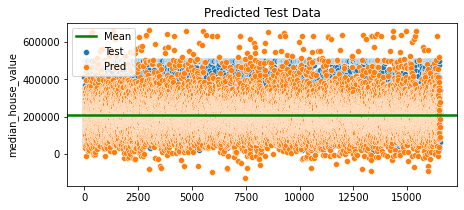

In [25]:
model_validation(LR1, x_test, y_test)

In the model evaluation part, the error rates were obtained at values that could not be called bad. But better results can be obtained. The reason why the best result could not be obtained is that few independent values are used in the model.

In [26]:
#separate the other attributes from the predicting attribute
#x = housing_df_raw.drop('median_house_value',axis=1)
#separte the predicting attribute into Y for model training 
#y = ['median_house_value']

In [27]:
# importing train_test_split from sklearn
#from sklearn.model_selection import train_test_split
# splitting the data
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [28]:
model_validation

<function __main__.model_validation>

In [29]:
# importing r2_score module
#from sklearn.metrics import r2_score
#from sklearn.metrics import mean_squared_error
# predicting the accuracy score
#score=r2_score(y_test,y_prediction)
#print(‘r2 socre is ‘,score)
#print(‘mean_sqrd_error is==’,mean_squared_error(y_test,y_prediction))
#print(‘root_mean_squared error of is==’,np.sqrt(mean_squared_error(y_test,y_prediction)))

# Data Preparation (II)

# Modeling & Evaluation (II)

<u>Questions:</u>
 - _----    In this section the main questions are addressed by the final comments section in which different conclusions need to be extracted and defended    ----_

The ML model used in Model 2 has not changed. LinearRegression is used as in Model1. The change made in Model2 is to increase the number of independent values used. Thus, more specific results could be obtained according to increasing parameters.

In [30]:
train_pct = 0.8
train, test = train_test_split(housing_df_raw, train_size=0.8) #split

print('\n\nFunction output:\n\t- Train:', len(train), '\n\t- Test:', len(test))



Function output:
	- Train: 16512 
	- Test: 4128


In [31]:
from sklearn import linear_model

housing_df_raw.columns

x_train = train[['longitude', 'latitude','median_income','ocean_proximity_int']]
y_train = train['median_house_value']


In [32]:
# importing module
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR2 = LinearRegression()
# fitting the training data
LR2.fit(x_train,y_train)

LinearRegression()

In [33]:
x_test = train[['longitude', 'latitude','median_income','ocean_proximity_int']]
y_test = train['median_house_value']

In [34]:
y_prediction =  LR2.predict(x_train)
print(y_prediction)
print(y_train)

[236210.97018212 217922.51182996 232608.23297328 ... 153611.33332794
 144138.85086247 198161.92991631]
18475    239300.0
5473     334700.0
17424    111500.0
12377    131900.0
13685    140200.0
           ...   
15170    169400.0
13794     84900.0
187      137500.0
14280     87500.0
17478    316700.0
Name: median_house_value, Length: 16512, dtype: float64


- MAE:		 53118.5752 
- MSE:		 5312621076.9942 
- RMSE:		 72887.7293 
- var(Y_pred):	 7882036446.2571 
- std(Y_pred):	 88780.8338 
- R2:		 0.5974



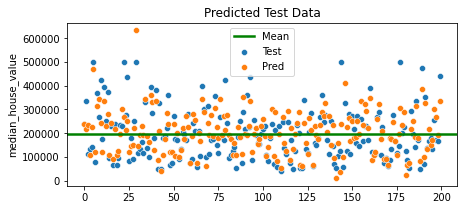

In [35]:
model_validation(LR2, x_test, y_test, plot_samples=200)

Due to the increase in the number of independent values used, the rate in the number of errors decreased and a better result was obtained. But for sure the model can still be improved

# Data Preparation (III)

# Modeling (III)

<u>Questions:</u>
 - _----    In this section the main questions are addressed by the final comments section in which different conclusions need to be extracted and defended    ----_

In Model3 the individual values remained the same. The ML model used has been changed. The ML pattern used in Model3 is RandomForestRegressor. A large number of decision trees are created with RandomForestRegressor, and the relationship between parameters is examined in more detail. Therefore RandomForestRegressor is used in Model3.

In [36]:
housing_df_clean = housing_df_raw.copy(deep=True)
housing_df_clean = housing_df_clean.dropna(how="any")
housing_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   longitude            20433 non-null  float64
 1   latitude             20433 non-null  float64
 2   housing_median_age   20433 non-null  float64
 3   total_rooms          20433 non-null  float64
 4   total_bedrooms       20433 non-null  float64
 5   population           20433 non-null  float64
 6   households           20433 non-null  float64
 7   median_income        20433 non-null  float64
 8   median_house_value   20433 non-null  float64
 9   ocean_proximity      20433 non-null  object 
 10  ocean_proximity_int  20433 non-null  int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 1.9+ MB


In [37]:
train_pct = 0.8
train, test = train_test_split(housing_df_clean, train_size=0.8) #split

print('\n\nFunction output:\n\t- Train:', len(train), '\n\t- Test:', len(test))



Function output:
	- Train: 16346 
	- Test: 4087


In [38]:
from sklearn import linear_model

housing_df_clean.columns

x_train = train[['longitude', 'latitude','median_income','ocean_proximity_int','total_rooms','total_bedrooms']]
y_train = train['median_house_value']


In [39]:
x_train.isna().sum()

longitude              0
latitude               0
median_income          0
ocean_proximity_int    0
total_rooms            0
total_bedrooms         0
dtype: int64

In [40]:
from sklearn.ensemble import RandomForestRegressor
# importing module
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR3 = RandomForestRegressor(n_estimators=200)
# fitting the training data
LR3.fit(x_train,y_train)

RandomForestRegressor(n_estimators=200)

In [41]:
x_test = train[['longitude', 'latitude','median_income','ocean_proximity_int','total_rooms','total_bedrooms']]
y_test = train['median_house_value']

In [42]:
y_prediction =  LR3.predict(x_train)
print(y_prediction)
print(y_train)

[115342.5 177114.  242286.5 ... 104834.  330240.  208108. ]
9202     122300.0
19919    177300.0
13115    241100.0
10398    286000.0
19114    291100.0
           ...   
19035    101100.0
4555     162500.0
4969     103600.0
10320    335600.0
12731    225700.0
Name: median_house_value, Length: 16346, dtype: float64


- MAE:		 11582.7905 
- MSE:		 323323268.359 
- RMSE:		 17981.1921 
- var(Y_pred):	 11956516949.6192 
- std(Y_pred):	 109345.8593 
- R2:		 0.9759



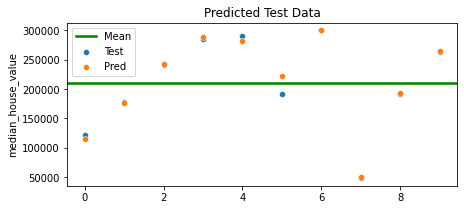

In [43]:
model_validation(LR3, x_test, y_test, plot_samples=10)

A large number of decision trees were created with RandomForestRegressor, and the relationship between parameters was examined in more detail. In this way, the error rate is very much reduced and the best model is obtained.